In [1]:
! pip install sklearn-pandas
! pip install seaborn
! pip install imbalanced-learn
! pip install lifelines
! pip install pycox
! pip install ttach

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=acaa0df06fe6c26bfa461c1079fe2707ef707a17c7bd7279434053db4a4f3ef

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines.utils import concordance_index

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from sklearn.model_selection import KFold
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
import pickle

import torch.nn as nn
from sklearn.utils import resample
import shutil

In [3]:
import torch 
import torchtuples as tt 

In [4]:
from pycox.models import CoxTime
from pycox.models import LogisticHazard
from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
class MLPModel(nn.Module):
    def __init__(self, in_features, out_features, dropout_rates=[0.3, 0.4, 0.5], batch_norm=True):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[0]),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[1]),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[2]),

            nn.Linear(32, out_features)  # Output layer
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
def train_model(X_train, y_train, X_val, y_val):
    
    num_unique_durations = len(np.unique(y_train[0]))
    num_durations = min(50, num_unique_durations - 1)
    labtrans = DeepHitSingle.label_transform(num_durations)

    y_train_transformed = labtrans.fit_transform(y_train[0], y_train[1])
    y_val_transformed = labtrans.transform(y_val[0], y_val[1])

    in_features = X_train.shape[1]
    out_features = labtrans.out_features
    net = MLPModel(in_features, out_features)

    model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

    batch_size = 64
    epochs = 100
    callbacks = [tt.cb.EarlyStopping(patience=5, min_delta=0.001)]

    log = model.fit(
        X_train, y_train_transformed,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        val_data=(X_val, y_val_transformed)
    )

    _ = log.plot()
    
    return model, labtrans

In [8]:
import numpy as np
import scipy.integrate

# Patch scipy.integrate.simps if missing (pycox depends on it)
if not hasattr(scipy.integrate, "simps"):
    try:
        from scipy.integrate import simpson
        scipy.integrate.simps = simpson
        print("✅ Patched scipy.integrate.simps with simpson")
    except ImportError:
        scipy.integrate.simps = np.trapz
        print("⚠️ Patched scipy.integrate.simps with np.trapz")

from pycox.evaluation import EvalSurv

def evaluate_model(model, labtrans, X_test, y_test):
    durations = y_test[0].numpy()
    events = y_test[1].numpy()

    # Check for invalid evaluation conditions
    if len(durations) == 0:
        print("⚠️ Skipping evaluation: test set is empty.")
        return None, None, None, None
    if np.sum(events) == 0:
        print("⚠️ Skipping evaluation: all test samples are censored.")
        return None, None, None, None
    if len(np.unique(durations)) == 1:
        print("⚠️ Skipping evaluation: all durations are the same.")
        return None, None, None, None

    # Predict survival curves
    surv = model.predict_surv_df(X_test.numpy())

    try:
        ev = EvalSurv(surv, durations, events, censor_surv='km')
        c_index = ev.concordance_td('antolini')
        time_grid = np.linspace(durations.min(), durations.max(), 100)
        ibs = ev.integrated_brier_score(time_grid)
        nbll = ev.integrated_nbll(time_grid)
    except Exception as e:
        print(f"⚠️ Error during evaluation: {e}")
        return surv, np.nan, np.nan, np.nan

    return surv, c_index, ibs, nbll

✅ Patched scipy.integrate.simps with simpson


In [9]:
from lifelines.utils import concordance_index
import numpy as np

def evaluate_random_times(y_test):
    durations = y_test[0].numpy()
    events = y_test[1].numpy()

    # Skip if invalid
    if len(durations) == 0:
        print("⚠️ Skipping: test set is empty.")
        return None, None, None
    if np.sum(events) == 0:
        print("⚠️ Skipping: all test samples are censored.")
        return None, None, None
    if len(np.unique(durations)) == 1:
        print("⚠️ Skipping: all durations are the same.")
        return None, None, None

    # Generate random survival functions (exponential decay)
    n_samples = len(durations)
    time_grid = np.linspace(durations.min(), durations.max(), 100)
    random_lambdas = np.random.uniform(low=durations.min(), high=durations.max(), size=n_samples)
    surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)

    # Convert to survival dataframe (time x samples)
    surv_df = pd.DataFrame(surv_matrix.T, index=time_grid)

    # Evaluate
    try:
        ev = EvalSurv(surv_df, durations, events, censor_surv='km')
        c_index = ev.concordance_td('antolini')
        ibs = ev.integrated_brier_score(time_grid)
        nbll = ev.integrated_nbll(time_grid)
    except Exception as e:
        print(f"⚠️ Evaluation error: {e}")
        return None, None, None

    return c_index, ibs, nbll

In [10]:
def preprocess_data(df_train, df_val, df_test):
    
    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train.drop(columns=['adjusted_duration', 'event']))
    val_features = scaler.transform(df_val.drop(columns=['adjusted_duration', 'event']))
    test_features = scaler.transform(df_test.drop(columns=['adjusted_duration', 'event']))

    X_train = torch.tensor(train_features, dtype=torch.float32)
    y_train = (torch.tensor(df_train['adjusted_duration'].values, dtype=torch.float32),
               torch.tensor(df_train['event'].values, dtype=torch.float32))

    X_val = torch.tensor(val_features, dtype=torch.float32)
    y_val = (torch.tensor(df_val['adjusted_duration'].values, dtype=torch.float32),
             torch.tensor(df_val['event'].values, dtype=torch.float32))

    X_test = torch.tensor(test_features, dtype=torch.float32)
    y_test = (torch.tensor(df_test['adjusted_duration'].values, dtype=torch.float32),
              torch.tensor(df_test['event'].values, dtype=torch.float32))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
def compute_ettc(surv_df, frame_interval=0.1):
    ettc_values = []
    
    for col_index in range(surv_df.shape[1]):
        
        survival_probs = []
        for row_index in range(surv_df.shape[0]):
            prob = surv_df.iloc[row_index, col_index]
            survival_probs.append(prob)
        
        ettc = 0.0
        for t, s_prob in enumerate(survival_probs):
            contribution = s_prob * frame_interval
            ettc += contribution
        
        ettc_values.append(ettc)
    
    return np.array(ettc_values)

In [12]:
def plot_survival_curves(surv, y_test, index=1, threshold=0.5, frame_interval=0.1, save_path=None, frame_id=None):
    event_time = y_test[0][index].item()
    event_occurred = y_test[1][index].item()
    fps = 10

    if event_time < 0:
        print(f"Skipping plot for index {index} due to negative event_time ({event_time})")
        return

    # Get survival curve for the given index (column)
    surv_probs = surv.iloc[:, index]
    times = surv.index.to_numpy()

    # Compute ETTC (Expected Time To Collision)
    ettc = np.sum(surv_probs.to_numpy() * frame_interval)

    # Compute threshold-based time (first time S(t) < threshold)
    below_thresh_idx = np.where(surv_probs < threshold)[0]
    threshold_time = times[below_thresh_idx[0]] if len(below_thresh_idx) > 0 else times[-1]

    # Calculate frame time using fps (if both frame_id and fps given)
    frame_time = None
    if frame_id is not None and fps is not None and fps > 0:
        frame_time = frame_id / fps

    # Start plotting
    plt.figure(figsize=(9, 6))
    plt.plot(times, surv_probs, drawstyle='steps-post', label="Survival Curve", color='blue')

    # Actual event time (if occurred)
    if event_occurred and event_time <= 5:
        plt.axvline(x=event_time, color='red', linestyle='dashed', label="Actual Event Time")
        closest_idx = np.argmin(np.abs(times - event_time))
        plt.scatter(event_time, surv_probs.iloc[closest_idx], color='red', zorder=5)

    # Threshold line
    plt.axvline(x=threshold_time, color='green', linestyle='dotted', label=f"Threshold Crossing (t={threshold_time:.2f}s)")

    # ETTC line
    plt.axvline(x=ettc, color='orange', linestyle='dashdot', label=f"ETTC = {ettc:.2f}s")

    # Labels and aesthetics
    plt.ylabel('Survival Probability S(t | x)')
    plt.xlabel('Time (seconds)')
    plt.ylim(0, 1.05)
    plt.xlim(0, 5)
    plt.title('Survival Curve with ETTC and Threshold Crossing')
    plt.grid(True)
    plt.legend()

    # Add frame ID and frame time below the x-axis, centered
    if frame_id is not None and frame_time is not None:
        plt.figtext(0.5, 0.01, f"Frame ID: {frame_id}    |    Current Time: {frame_time:.2f}s",
                    ha='center', fontsize=12)

    # Show image if provided (from save_path)
    if save_path:
        try:
            img = mpimg.imread(save_path)
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            ax_img = inset_axes(plt.gca(), width="30%", height="30%", loc='upper right')
            ax_img.imshow(img)
            ax_img.axis('off')
        except Exception as e:
            print(f"Could not load image from {save_path}: {e}")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Survival curve plot saved to {save_path}")

    plt.show()

In [13]:
def compute_predicted_times(surv_test, threshold):
    predicted_times = []
    for col in surv_test.columns:
        surv_probs = surv_test[col]
        below_thresh = surv_probs[surv_probs < threshold]

        time_to_event = below_thresh.index[0] if not below_thresh.empty else surv_probs.index[-1]
        predicted_times.append(time_to_event)
    return np.array(predicted_times)

In [14]:
def plot_actual_vs_predicted(true_times, predicted_times, frame_id):
    plt.figure(figsize=(8, 6))

    # Scatter plot of actual vs predicted times for both optimal threshold and weighted average
    for label, predicted in predicted_times.items():
        plt.scatter(true_times, predicted, alpha=0.6, edgecolor='k', label=label)

    # Ideal fit line (y = x)
    plt.plot([0, 5], [0, 5], 'k--', label='Ideal Fit Line')  # Adjusted to fit within [0,5]

    plt.xlabel('Actual Time to Event (s)')
    plt.ylabel('Predicted Time to Event (s)')
    plt.xlim(0, 5)  # Set x-axis limit to 0-5
    plt.ylim(0, 5)  # Set y-axis limit to 0-5
    plt.legend()
    plt.title(f'Scatter Plot: Frame {frame_id}')
    plt.grid(True)
    plt.show()

In [15]:
def plot_scatter_under_threshold(surv_df, y_test, threshold, frame_id):
    
    filtered_probs = []
    true_ttas = []
    sizes = []
    colors = []

    for i in range(len(y_test[0])):
        event = y_test[1][i].item()
        tta = y_test[0][i].item()

        if event != 1:
            continue

        # Extract survival prob curve for this instance
        survival_probs = surv_df.iloc[:, i].values
        times = surv_df.index.to_numpy()
        predicted_probs = 1 - survival_probs  # Convert to CDF

        # Filter only frames where prob <= threshold and time <= TTA
        valid_indices = np.where((predicted_probs <= threshold) & (times <= tta))[0]
        if len(valid_indices) == 0:
            continue

        for idx in valid_indices:
            filtered_probs.append(predicted_probs[idx])
            true_ttas.append(tta)
            sizes.append(40 + tta * 10)  # Size varies with TTA
            colors.append(i)  # Color by sequence ID (index)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(filtered_probs, true_ttas, c=colors, s=sizes, cmap='viridis', alpha=0.6, edgecolor='k')
    plt.colorbar(scatter, label="Sequence Index")
    plt.xlabel("Predicted Probability (1 - S(t))")
    plt.ylabel("Ground Truth TTA (s)")
    plt.title(f"Scatter Plot (Under Threshold) - Frame {frame_id}")
    plt.grid(True)
    plt.show()

In [16]:
def calculate_correlation(actual_times, predicted_times):
     # Correlation Coefficient
    correlation_coefficient = np.corrcoef(actual_times, predicted_times)[0, 1]
    print(f"Correlation between expected time and true time (Optimal Threshold): {correlation_coefficient:.4f}")

    # Create a DataFrame to show actual and predicted times side by side
    comparison_df = pd.DataFrame({
        'Actual_Time': actual_times,
        'Predicted_Mean_Time': predicted_times
    })

In [17]:
def plot_combined_scatter(true_times, predicted_threshold, predicted_ettc):
    plt.figure(figsize=(10, 7))

    plt.scatter(true_times, predicted_threshold, alpha=0.5, label="Threshold-based Prediction", color='dodgerblue', edgecolor='k')

    # Ideal fit line (y = x)
    plt.plot([0, 5], [0, 5], 'k--', label='Ideal Fit Line')

    plt.xlabel('Actual Time to Event (s)')
    plt.ylabel('Predicted Time to Event (s)')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title("Combined Scatter Plot for All Frames (True vs Predicted Times)")
    plt.legend()
    plt.grid(True)
    plt.show()

    
    plt.figure(figsize=(10, 7))

    plt.scatter(true_times, predicted_ettc, alpha=0.5, label="ETTC (Expected Time)", color='orange', edgecolor='k')

    # Ideal fit line (y = x)
    plt.plot([0, 5], [0, 5], 'k--', label='Ideal Fit Line')

    plt.xlabel('Actual Time to Event (s)')
    plt.ylabel('Predicted Time to Event (s)')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title("Combined Scatter Plot for All Frames (True vs Predicted Times)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
import os
import pandas as pd

def load_frame_data(fold_id, frame_id):
    train_path = os.path.join(f"/kaggle/input/dota-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_train", f"frame_{frame_id}.csv")
    test_path = os.path.join(f"/kaggle/input/dota-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_test", f"frame_{frame_id}.csv")

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print(f"Fold {fold_id}, Frame {frame_id} missing.")
        return None, None, None

    df_trainval = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    epsilon = 1e-6  # Tolerance for float errors

    # Adjust durations and remove rows with adjusted_duration <= 0 before censoring fix
    for df_name, df in zip(['trainval', 'test'], [df_trainval, df_test]):
        df['adjusted_duration'] = df['duration'] - (frame_id - 1) * 0.1
        original_len = len(df)

        # Keep rows with adjusted_duration >= -epsilon
        df = df[df['adjusted_duration'] >= -epsilon].copy()

        # Clamp very small negatives to zero
        df.loc[df['adjusted_duration'] < 0, 'adjusted_duration'] = 0.0

        # Set censored events duration to 5.0
        df.loc[df['event'] == 0, 'adjusted_duration'] = 5.0

        print(f"Removed {original_len - len(df)} rows with adjusted_duration <= 0 in {df_name} set.")

        if 'file_id' in df.columns:
            df.drop(columns=['file_id'], inplace=True)

        if df_name == 'trainval':
            df_trainval = df
        else:
            df_test = df

    # Split train and val
    df_val = df_trainval.sample(frac=0.2, random_state=42)
    df_train = df_trainval.drop(df_val.index)

    return df_train, df_val, df_test

Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 4 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 8 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test set.
Removed 9 rows with adjusted_duration <= 0 in trainval set.
Removed 4 rows with adjusted_duration <= 0 in test set.
Removed 11 rows with adjusted_duration <= 0 in trainval set.
Removed 4 rows with adjusted_duration <= 0 in test set.
Removed 12 rows with adjusted_duration <= 0 in trainval set.
Removed 4 rows with adjusted_duration <= 0 in test set.
Removed 17 rows with adjusted_duration <= 0 in trainval set.
Removed 4 rows with adjusted_duration <= 0 in test set.
Removed 21 rows with adjusted_duration <= 0 in trainval set.
Removed 

/tmp/ipykernel_13/379114051.py:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_1.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 1):
C-index: 0.9764
IBS:     0.0354
NBLL:    0.1345
Random C-index: 0.4342
Random IBS:     0.4365
Random NBLL:    1.9677
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 4 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test se

/tmp/ipykernel_13/379114051.py:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_2.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 2):
C-index: 0.9688
IBS:     0.0475
NBLL:    0.1697
Random C-index: 0.4471
Random IBS:     0.4346
Random NBLL:    1.9972
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 5 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 8 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duratio

/tmp/ipykernel_13/379114051.py:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_3.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 3):
C-index: 0.9798
IBS:     0.0370
NBLL:    0.1356
Random C-index: 0.4501
Random IBS:     0.4357
Random NBLL:    1.9530
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 3 rows with adjusted_duration <= 0 in trainval set.
Removed 2 rows with adjusted_duration <= 0 in test set.
Removed 6 rows with adjusted_duration <= 0 in trainval set.
Removed 3 rows with adjusted_duration <= 0 in test set.
Removed 9 rows with adjusted_duration <= 0 in trainval set.
Removed 4 rows with

/tmp/ipykernel_13/379114051.py:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_4.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 4):
C-index: 0.9747
IBS:     0.0368
NBLL:    0.1325
Random C-index: 0.4398
Random IBS:     0.4371
Random NBLL:    1.9961
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 0 rows with adjusted_duration <= 0 in trainval set.
Removed 0 rows with adjusted_duration <= 0 in test set.
Removed 4 rows with adjusted_duration <= 0 in trainval set.
Removed 1 rows with adjusted_duration <= 0 in test se

/tmp/ipykernel_13/379114051.py:23: RuntimeWarning: divide by zero encountered in divide
  surv_matrix = np.exp(-np.outer(random_lambdas, 1.0 / time_grid))  # shape: (n_samples, time_grid)


⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
⚠️ Skipping evaluation: all test samples are censored.
⚠️ Skipping: all test samples are censored.
[✓] Saved fold results to tta_framewise_csvs/fold_5.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 5):
C-index: 0.9777
IBS:     0.0349
NBLL:    0.1370
Random C-index: 0.4407
Random IBS:     0.4383
Random NBLL:    2.0020
✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'
✅ Average metrics saved to 'average_evaluation_metrics.csv'


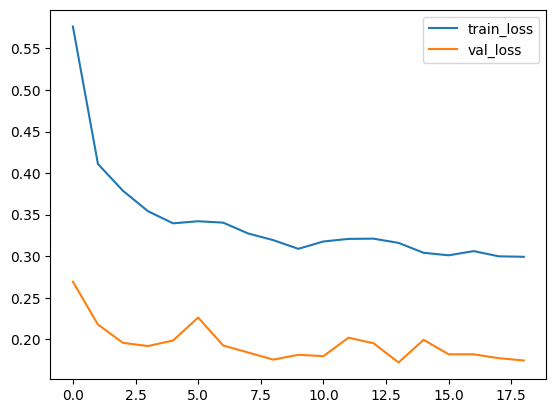

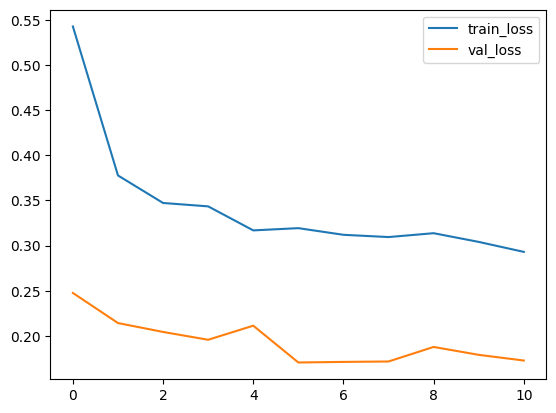

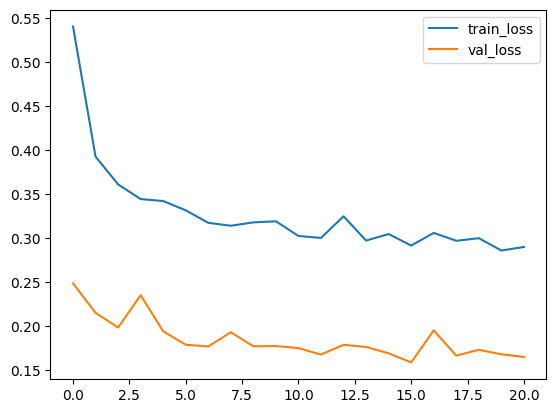

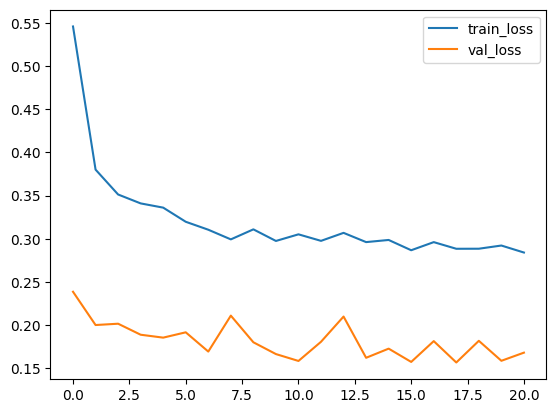

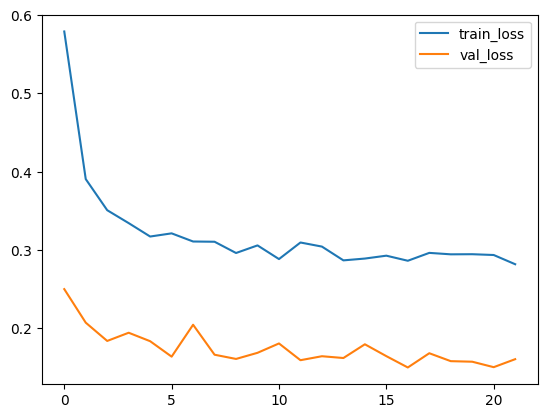

In [19]:
output_dir = "tta_framewise_csvs"
survival_curves = "survival_curves"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(survival_curves, exist_ok=True)
def process_and_collect_all_frames():
    all_true_times_folds, all_predicted_threshold_folds, all_predicted_ettc_folds = [], [], []
    for fold_id in range(1, 6):        
        all_X_train, all_X_val, all_y_train, all_y_val, test_data = [], [], [], [], []
        c_indices, ibs_scores, nbll_scores = [], [], []
        c_indices_random, ibs_scores_random, nbll_scores_random = [], [], []
        all_true_times, all_predicted_threshold, all_predicted_ettc = [], [], []
        
        fold_metrics = []


        fold_results = []  

        for frame_id in range(1, 51):  
            df_train, df_val, df_test = load_frame_data(fold_id, frame_id)

            
            if df_train is None:
                continue  

            X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_val, df_test)
            
            all_X_train.append(X_train)
            all_X_val.append(X_val)
            all_y_train.append(y_train)
            all_y_val.append(y_val)
            test_data.append((frame_id, X_test, y_test))

        
        X_train_all = np.concatenate(all_X_train)
        y_train_all = (np.concatenate([y[0] for y in all_y_train]), np.concatenate([y[1] for y in all_y_train]))

        X_val_all = np.concatenate(all_X_val)
        y_val_all = (np.concatenate([y[0] for y in all_y_val]), np.concatenate([y[1] for y in all_y_val]))

        model, labtrans = train_model(X_train_all, y_train_all, X_val_all, y_val_all)


        for frame_id, X_test, y_test in test_data:
            
            surv, c_index, ibs, nbll = evaluate_model(model, labtrans, X_test, y_test)
            c_index_random, ibs_random, nbll_random = evaluate_random_times(y_test)

            if surv is None:
                continue
                
            c_indices.append(c_index)
            ibs_scores.append(ibs)
            nbll_scores.append(nbll)
            c_indices_random.append(c_index_random)
            ibs_scores_random.append(ibs_random)
            nbll_scores_random.append(nbll_random)

            true_times_test = y_test[0].numpy()
            predicted_times_optimal = compute_predicted_times(surv, 0.5)
            predicted_times_ettc = compute_ettc(surv)


            correlation = np.corrcoef(true_times_test, predicted_times_ettc)[0, 1]

            for t, pt_thresh, pt_ettc in zip(true_times_test, predicted_times_optimal, predicted_times_ettc):
                fold_results.append({
                    'Frame_ID': frame_id,
                    'True_Time': t,
                    'Predicted_TTC_Threshold': pt_thresh,
                    'Predicted_ETTC': pt_ettc
                })

            all_true_times.extend(true_times_test)
            all_predicted_threshold.extend(predicted_times_optimal)
            all_predicted_ettc.extend(predicted_times_ettc)

        df_fold = pd.DataFrame(fold_results)
        fold_csv_path = os.path.join(output_dir, f'fold_{fold_id}.csv')
        df_fold.to_csv(fold_csv_path, index=False)
        print(f"[✓] Saved fold results to {fold_csv_path}")
        # Aggregate all fold predictions into global lists
        all_true_times_folds.extend(all_true_times)
        all_predicted_threshold_folds.extend(all_predicted_threshold)
        all_predicted_ettc_folds.extend(all_predicted_ettc)

        print("\n=== Final Aggregated Evaluation ===")
        if c_indices:
            mean_c_index = np.mean(c_indices)
            mean_ibs = np.mean(ibs_scores)
            mean_nbll = np.mean(nbll_scores)
        
            mean_c_index_random = np.mean(c_indices_random)
            mean_ibs_random = np.mean(ibs_scores_random)
            mean_nbll_random = np.mean(nbll_scores_random)
        
            print(f"\n📊 Final Aggregated Evaluation Metrics (Fold {fold_id}):")
            print(f"C-index: {mean_c_index:.4f}")
            print(f"IBS:     {mean_ibs:.4f}")
            print(f"NBLL:    {mean_nbll:.4f}")
            print(f"Random C-index: {mean_c_index_random:.4f}")
            print(f"Random IBS:     {mean_ibs_random:.4f}")
            print(f"Random NBLL:    {mean_nbll_random:.4f}")
        
            fold_metrics.append({
                'fold': fold_id,
                'c_index': mean_c_index,
                'ibs': mean_ibs,
                'nbll': mean_nbll,
                'c_index_random': mean_c_index_random,
                'ibs_random': mean_ibs_random,
                'nbll_random': mean_nbll_random
            })
        else:
            print("No valid frames for this fold.")

    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.to_csv("fold_evaluation_metrics.csv", index=False)

    avg_metrics = metrics_df.mean(numeric_only=True)
    avg_metrics_df = pd.DataFrame([avg_metrics])
    avg_metrics_df.to_csv("average_evaluation_metrics.csv", index=False)

    print("✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'")
    print("✅ Average metrics saved to 'average_evaluation_metrics.csv'")
    
    return (np.array(all_true_times_folds),
            np.array(all_predicted_threshold_folds),
            np.array(all_predicted_ettc_folds))

true_all, pred_thresh_all, pred_ettc_all = process_and_collect_all_frames()
true_times = np.array(true_all)  

# plot_combined_scatter(true_all, pred_thresh_all, pred_ettc_all)

In [20]:
np.random.seed(1234)
_ = torch.manual_seed(123)
random_preds = np.random.uniform(low=true_times.min(), high=true_times.max(), size=true_times.shape)

In [21]:
comparison_df = pd.DataFrame({
    'True_Time': true_all,
    'Pred_Threshold': pred_thresh_all,
    'Pred_ETTC': pred_ettc_all,
    'Random_Pred': random_preds
})

# Print full DataFrame
# print(comparison_df.to_string(index=False))
# Save DataFrame as CSV
comparison_df.to_csv("comparison_results.csv", index=False)
print("CSV file saved successfully.")

CSV file saved successfully.


In [22]:
import pandas as pd

# Load the CSV file
file_path = "comparison_results.csv"  # Replace with your actual file path
try:
    df = pd.read_csv(file_path)
    
    # Calculate the correlation matrix
    correlation_matrix = df[['True_Time', 'Pred_Threshold', 'Pred_ETTC', 'Random_Pred']].corr()
    
    # Print the correlation matrix
    print("\nCorrelation Coefficients:")
    print(correlation_matrix)
    
    # Save the correlation matrix to a CSV file
    correlation_matrix.to_csv("correlation_matrix.csv", index=True)
    print("\nCorrelation matrix saved as 'correlation_matrix.csv'.")
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path and try again.")



Correlation Coefficients:
                True_Time  Pred_Threshold  Pred_ETTC  Random_Pred
True_Time        1.000000        0.959579   0.954009     0.006663
Pred_Threshold   0.959579        1.000000   0.985334     0.005743
Pred_ETTC        0.954009        0.985334   1.000000     0.006647
Random_Pred      0.006663        0.005743   0.006647     1.000000

Correlation matrix saved as 'correlation_matrix.csv'.
